In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import tensor
from utils.load_folktables import prepare_folktables, prepare_folktables_multattr
from humancompatible.train.constraints.constraint_fns import *
from fairret.statistic import *
from utils.network import SimpleNet

This notebook presents some useful plots based on the performance of the trained models.

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [ ]:
TASK = "income"
# TASK = 'employment'
STATE = "CA"

In [ ]:
(
    X_train,
    y_train,
    group_ind_train,
    sep_group_ind_train,
    X_test,
    y_test,
    group_ind_test,
    sep_group_ind_test,
) = prepare_folktables_multattr(
    TASK,
    state=STATE.upper(),
    random_state=42,
    onehot=False,
    download=True,
    sens_cols=[
        "MAR",
        # 'RAC1P',
        # 'SEX',
    ],
    binarize=[None],
    stratify=False,
)

In [ ]:
device = "cuda" if torch.cuda.is_available() and False else "cpu"

In [ ]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)

X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)

**Load saved models**

In [ ]:
from itertools import product

constraints = {
    'abs_loss_equality': 0.02,
    # "loss_equality": 0.005,
    "unconstrained": None,
}

dict_alg_names = {
    "StochasticGhost": "StGh",
    "ALM": "ALM",
    "SSLALM": "SSL-ALM",
    "SSG": "SSw",
    "SGD": "SGD",
    "fairret": "SGD-Fairret",
}

DATASET = TASK + "_" + STATE
loaded_models = []

for constr, cb in constraints.items():
    DIRECTORY_PATH = (
        "./utils/saved_models/" + DATASET + "/" + constr + "/" + ((f"{cb:.0E}" + "/") if cb is not None else '')
    )
    FILE_EXT = ".pt"

    directory_path = DIRECTORY_PATH
    print(f"Looking for models in: {directory_path}")
    try:
        file_list = os.listdir(directory_path)
    except FileNotFoundError:
        print("Not found")
        continue
    model_files = [file for file in file_list if file.endswith(FILE_EXT)]
    for model_file in model_files:
        if model_file.split("_")[0] not in dict_alg_names.keys():
            continue
        model_name = model_file
        model = SimpleNet(X_test.shape[1], 1, torch.float32).to(device)
        print(model_file)
        try:
            model.load_state_dict(
                torch.load(
                    directory_path + model_name, weights_only=False, map_location=device
                )
            )
        except:
            continue
        loaded_models.append((model_file, model))


Looking for models in: ./utils/saved_models/income_CA/abs_loss_equality/2E-02/
SSG_0.02_trial0.pt
SGD_0.02_trial0.pt
SSLALM_0.02_trial0.pt
Looking for models in: ./utils/saved_models/income_CA/unconstrained/
Not found


### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.. and aggregate per algorithm:**

In [ ]:
from utils.stats import make_pairwise_constraint_stats_table, aggregate_model_stats_table, make_groupwise_stats_table

**Train set**:

In [ ]:
full_data_stats = make_groupwise_stats_table(
    X_train_tensor,
    y_train_tensor,
    loaded_models
    ).drop('Model',axis=1).groupby('Algorithm').agg('mean')

groupwise_stats = []

for group_ind in group_ind_train:
    groupwise_stats.append(
        make_groupwise_stats_table(
            X_train_tensor[group_ind],
            y_train_tensor[group_ind],
            loaded_models
        ).drop('Model',axis=1).groupby('Algorithm').agg('mean')
    )

In [ ]:
groupwise_dev = []

for group_stats in groupwise_stats:
    diff = full_data_stats - group_stats
    diff = diff.add_suffix('_dev')
    diff['sep'] = abs(diff['tpr_dev']) + abs(diff['fpr_dev'])
    diff['suf'] = abs(diff['ppv_dev']) + abs(diff['fomr_dev'])
    diff['ind'] = abs(diff['pr_dev'])
    groupwise_dev.append(diff)


In [ ]:
groupwise_dev[0]

,acc_dev,auc_dev,fpr_dev,tpr_dev,ppv_dev,fomr_dev,pr_dev,sep,suf,ind
Algorithm,,,,,,,,,,
SGD_0.02,0.019215,0.020261,-0.0582,-0.029687,0.041293,0.010893,-0.110106,0.087887,0.052186,0.110106
SSG_0.02,0.015141,0.014042,-0.066598,-0.030809,0.039959,0.00961,-0.108092,0.097407,0.049569,0.108092
SSLALM_0.02,0.018984,0.013577,-0.056207,-0.028537,0.038578,0.008939,-0.104728,0.084744,0.047517,0.104728


In [ ]:
from itertools import combinations
import pandas as pd

bin_dfs = []

for group_idx_1, group_idx_2 in list(combinations(group_ind_train, 2)):
    X_train_1, y_train_1 = X_train_tensor[group_idx_1], y_train_tensor[group_idx_1]
    X_train_2, y_train_2 = X_train_tensor[group_idx_2], y_train_tensor[group_idx_2]
    table = make_pairwise_constraint_stats_table(
        X_train_1, y_train_1, X_train_2, y_train_2, loaded_models
    )
    table.index = table.Algorithm.apply(lambda x: dict_alg_names[x.split("_")[0]])
    table.drop("Algorithm", axis=1, inplace=True)
    bin_dfs.append(table)
    
df_train = pd.concat(bin_dfs, axis=0, keys=range(len(bin_dfs)), names=["constraint"])

In [ ]:
train_df = aggregate_model_stats_table(
    df_train, "mean", agg_cols=["constraint", "Algorithm"]
)
train_df_std = aggregate_model_stats_table(
    df_train, ["mean", "std"], agg_cols=["constraint", "Algorithm"]
)
train_df_std.drop("Algname", axis=1, inplace=True)

In [ ]:
train_df

AUC_M       Ind        Sp       Ina        Sf  \
constraint Algorithm                                                     
0          SGD        0.852367  0.093495  0.071876  0.214259  0.123354   
           SSL-ALM    0.832591  0.123732  0.141125  0.231042   0.10096   
           SSw        0.810868  0.158727  0.215431  0.245733  0.069402   
1          SGD        0.851448  0.037822  0.060259  0.217942  0.063313   
           SSL-ALM    0.831870  0.063849  0.074767  0.234417  0.057479   
           SSw        0.810818  0.074211  0.098793  0.249592  0.064296   
2          SGD        0.868003  0.194836  0.149258  0.212646  0.208013   
           SSL-ALM    0.842523  0.212348  0.206022  0.229453  0.203597   
           SSw        0.824599  0.205339  0.203536  0.244849  0.229192   
3          SGD        0.885300  0.289887  0.244988  0.188099  0.238532   
           SSL-ALM    0.859317  0.265331  0.207567  0.205605  0.293564   
           SSw        0.838765  0.270979  0.230109  0.224480  0.313318   
4          SGD        0.836811  0.055673  0.052599  0.243853  0.060041   
           SSL-ALM    0.816201  0.059883  0.066358  0.258022  0.059926   
           SSw        0.792179  0.084516  0.116638  0.273620  0.038871   
5          SGD        0.853366  0.101342  0.077382  0.215292  0.084659   
           SSL-ALM    0.826854  0.088616  0.064898  0.229915  0.102637   
           SSw        0.805961  0.046613  0.036317  0.249648   0.15979   
6          SGD        0.870663  0.196392  0.173111  0.154392  0.115178   
           SSL-ALM    0.843648  0.141598  0.096215  0.172651  0.192604   
           SSw        0.820127  0.112252  0.093999  0.196770  0.243916   
7          SGD        0.852447  0.157015  0.129981  0.235171    0.1447   
           SSL-ALM    0.826134  0.148499  0.131255  0.249521  0.162562   
           SSw        0.805910  0.131128  0.104743  0.268576   0.19866   
8          SGD        0.869744  0.252065  0.225711  0.169561  0.175218   
           SSL-ALM    0.842927  0.201481    0.1328  0.187142   0.25253   
           SSw        0.820076  0.196768  0.131316  0.210357  0.282787   
9          SGD        0.886299  0.095051   0.09573  0.152449   0.03194   
           SSL-ALM    0.853580  0.052982   0.04956  0.170733  0.089967   
           SSw        0.833858   0.06564  0.057682  0.195820  0.084127   

                            Wd  |Loss_0 - Loss_1| |TPR_0 - TPR_1|  acc_diff  \
constraint Algorithm                                                          
0          SGD        0.006760           0.034225        0.067484  0.028058   
           SSL-ALM    0.000878           0.003703        0.105936  0.025256   
           SSw        0.000393           0.002885        0.134587  0.019120   
1          SGD        0.001607           0.043264        0.039768  0.030914   
           SSL-ALM    0.000277           0.010018        0.066779  0.028231   
           SSw        0.000097           0.008062        0.077256  0.030219   
2          SGD        0.030068           0.036125        0.076756  0.020675   
           SSL-ALM    0.001912           0.003496        0.115058  0.022443   
           SSw        0.000637           0.000723        0.110481  0.008107   
3          SGD        0.085505           0.128916        0.116902  0.063179   
           SSL-ALM    0.002954           0.007810         0.09105  0.061589   
           SSw        0.001037           0.002568        0.094927  0.051613   
4          SGD        0.002062           0.009038        0.027716  0.002855   
           SSL-ALM    0.000206           0.006315        0.039157  0.002975   
           SSw        0.000123           0.005178        0.057331  0.011100   
5          SGD        0.009069           0.070350        0.009272  0.048733   
           SSL-ALM    0.000300           0.007198        0.009121  0.047700   
           SSw        0.000062           0.003608        0.024106  0.027226   
6          SGD        0.037918           0.163142        0.049418  0.091237 

**Plots:**

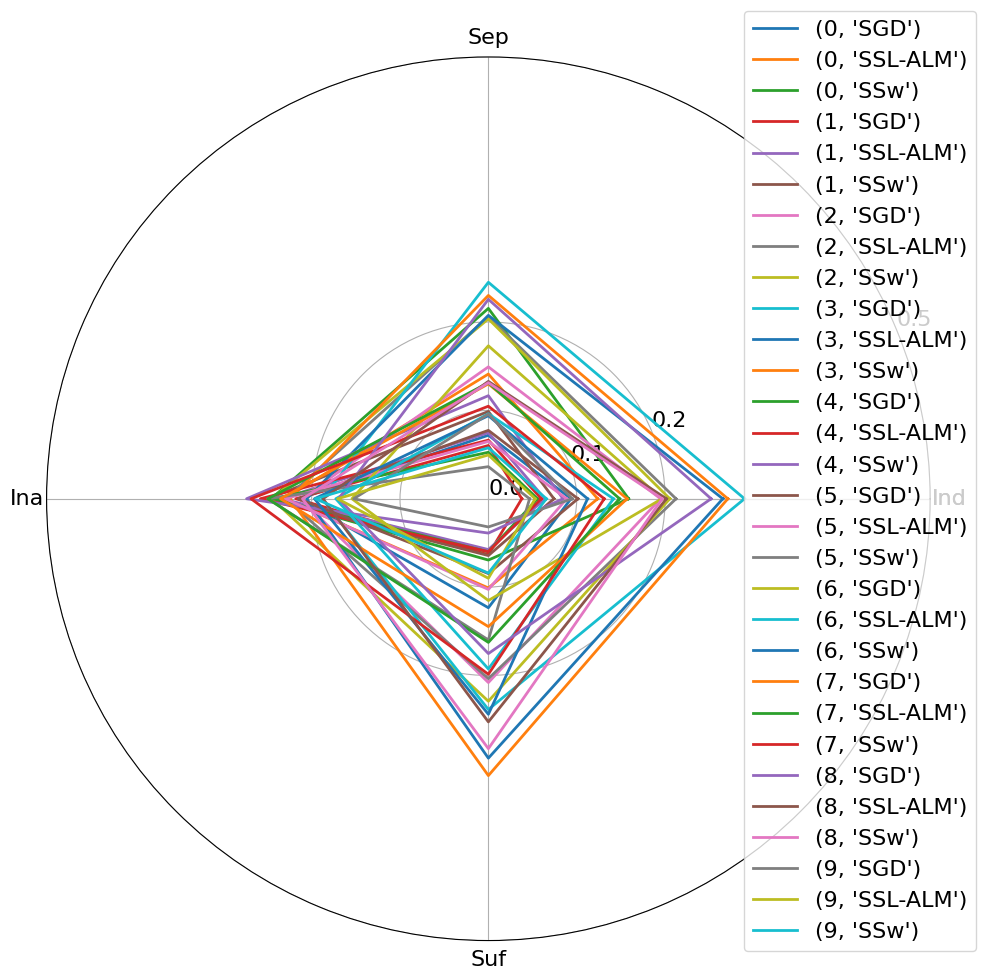

In [ ]:
from utils.plotting import spider_line


f = spider_line(train_df, yticks=[0,0.1,0.2,0.5])

**Distribution of predictions by group:**

In [ ]:
predictions_by_alg = {alg: {} for alg in set([model_name.split("_")[0] for model_name, _ in loaded_models])}


for i, group in enumerate(group_ind_test):
    for model_name, model in loaded_models:
        alg = model_name.split("_")[0]

        preds = torch.nn.functional.sigmoid(model(X_test_tensor[group])).detach().numpy().squeeze()
        try:
            predictions_by_alg[alg][i].append(preds)
        except:
            predictions_by_alg[alg][i] = [preds]

for alg in predictions_by_alg.keys():
    for i in predictions_by_alg[alg].keys():
        predictions_by_alg[alg][i] = np.concatenate(predictions_by_alg[alg][i])

In [ ]:
pred_dfs = {}

for alg, pred_dict in predictions_by_alg.items():
    preds = []
    groups = []
    for group, group_preds in pred_dict.items():
        preds.extend(group_preds)
        groups.extend([group]*len(group_preds))
    
    pred_dfs[alg] = (
        pd.DataFrame({'pred': preds, 'group': groups})
    )

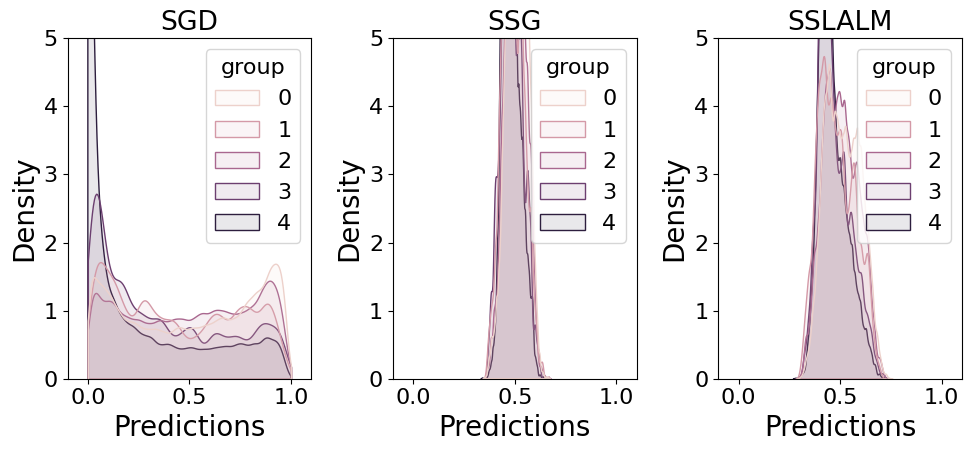

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=3)

for i, (alg, predictions) in enumerate(pred_dfs.items()):
    ax = axs[i]
    sns.kdeplot(
        predictions,
        x='pred',
        hue='group',
        fill=True,
        alpha=0.1,
        bw_adjust=0.4,
        ax=ax,
        clip=[0,1],
        common_norm=False)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 5)
    ax.set_xlabel("Predictions", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    ax.set_title(alg)

fig.set_figwidth(10)
fig.tight_layout()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [ ]:
df_train.index.get_level_values('Algorithm').unique()

Index(['SSw', 'SGD', 'SSL-ALM'], dtype='object', name='Algorithm')

In [ ]:
select_by = "AUC_M"

In [ ]:
best_models = {}
algs = df_train.index.get_level_values('Algorithm').unique()
for alg in algs:
    alg_df = df_train.xs(alg, level=1).reset_index()
    best_model_name = alg_df[['Model', select_by]].groupby('Model').mean()[select_by].idxmax()
    model = [(name, model) for name, model in loaded_models if name == best_model_name][0]
    best_models[alg] = model

#### Subgroup ROC

**TPR-FPR plot**

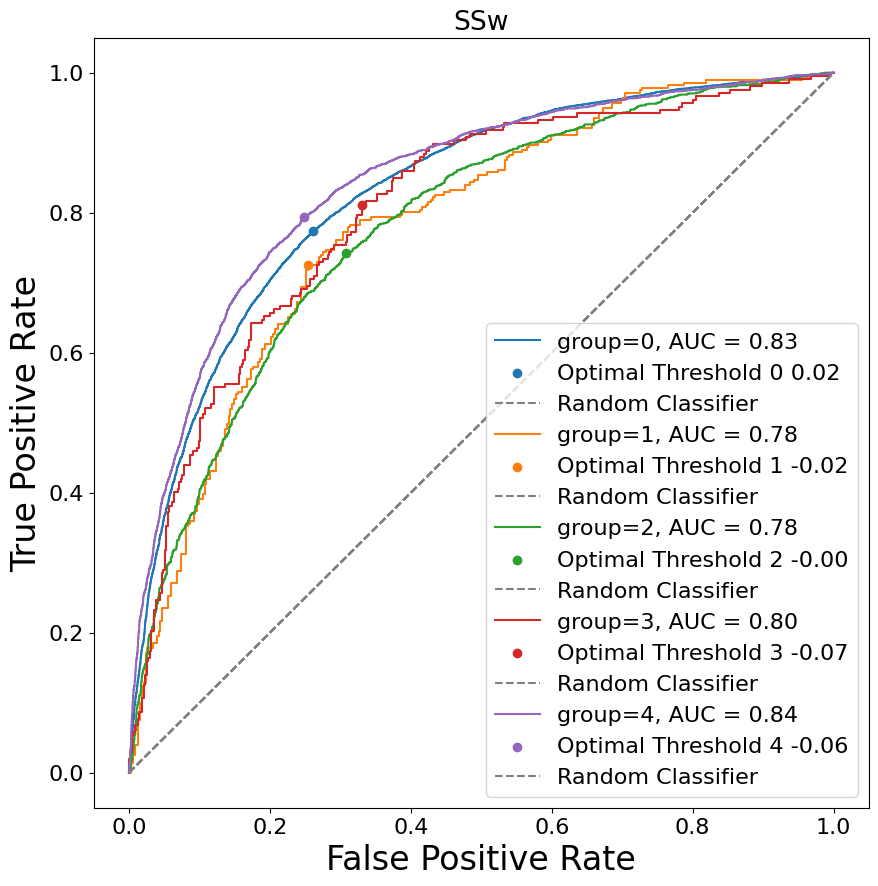

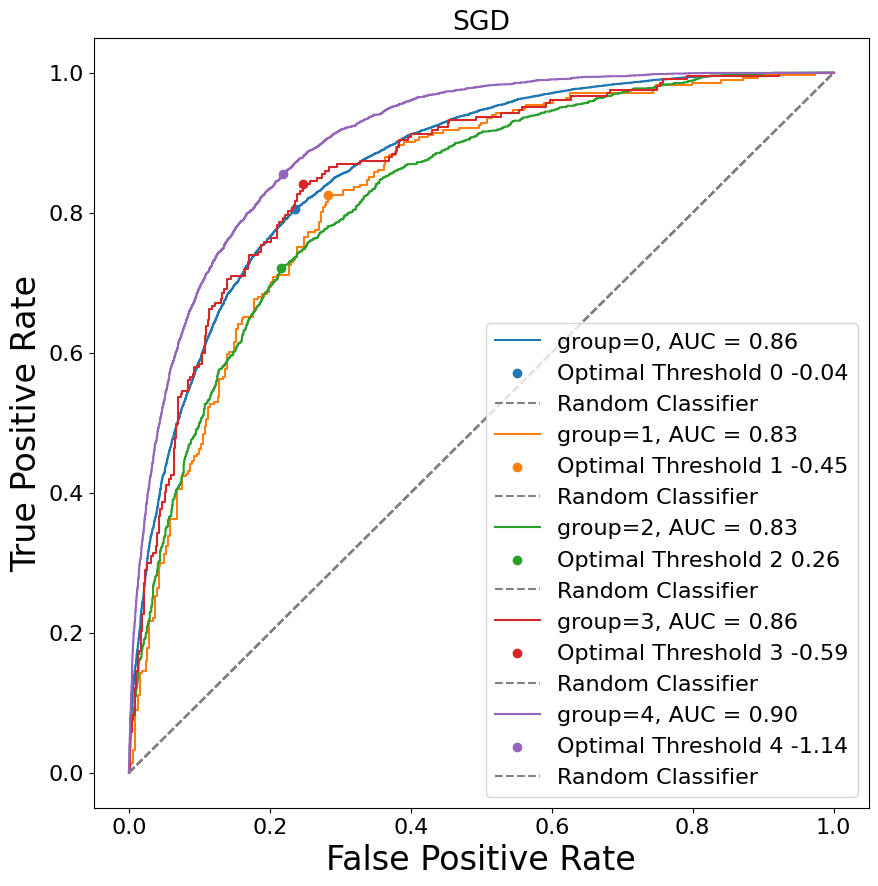

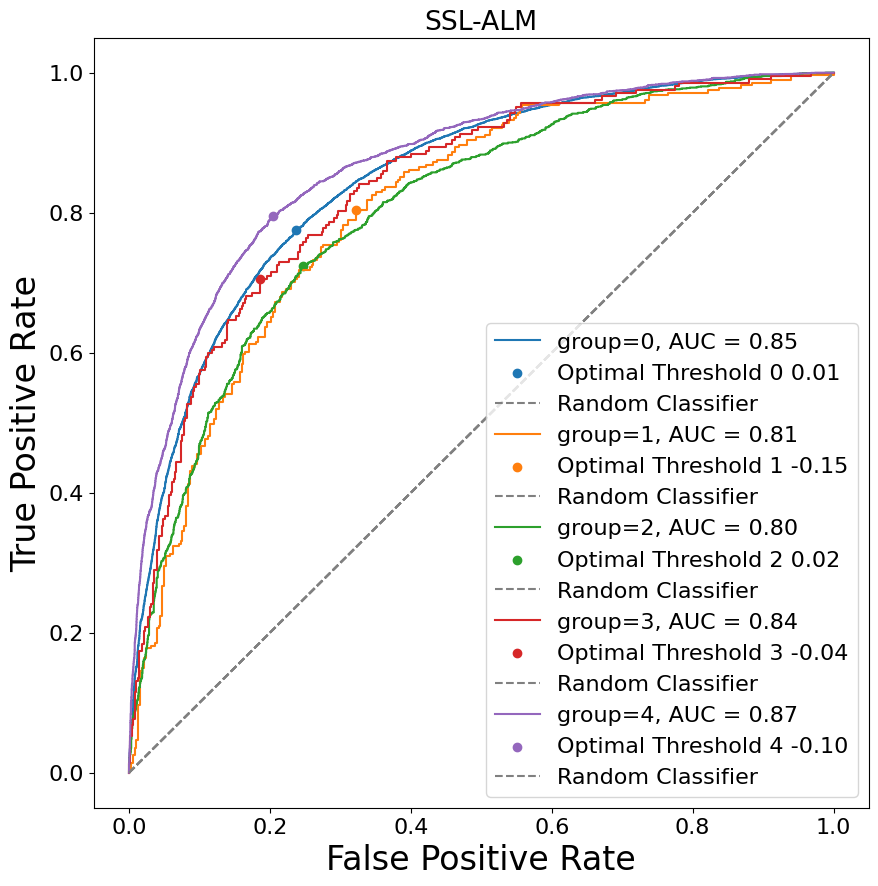

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"group={sensitive_value}, AUC = {roc_auc:.2f}")
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fpr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_pr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Positive Rate", fontsize=24)
            ax.set_ylabel("True Positive Rate", fontsize=24)
            ax.legend()

**TNR-FNR plot**

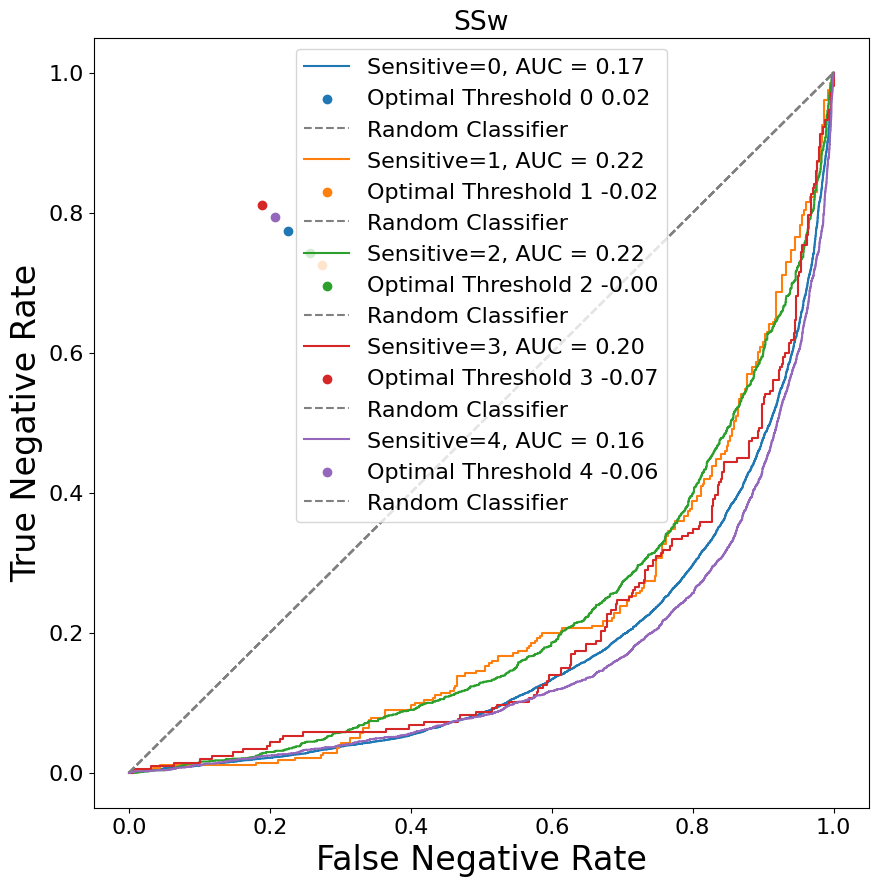

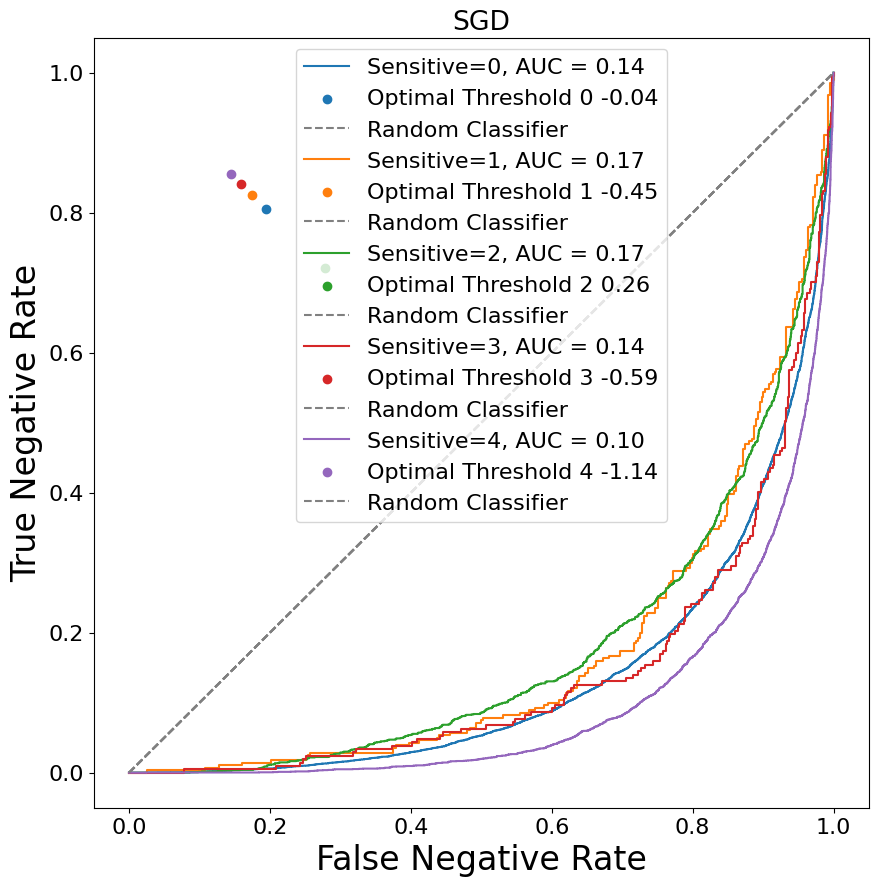

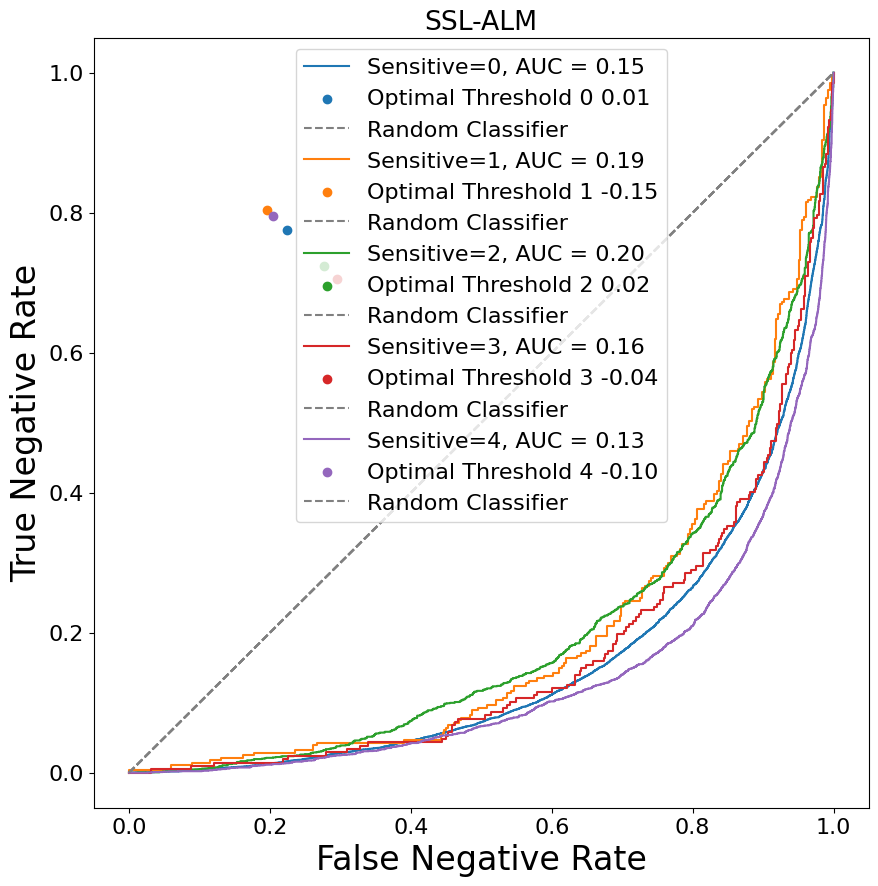

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    # predictions = predictions.detach().numpy()
    # targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = 1 - tpr
    tnr = 1 - fpr
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f"Sensitive={sensitive_value}, AUC = {roc_auc:.2f}")

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes tnr - fnr difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fnr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_nr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Negative Rate", fontsize=24)
            ax.set_ylabel("True Negative Rate", fontsize=24)
            ax.legend()